<a href="https://colab.research.google.com/github/prof-eduardo-nunes/unicamp-mineracao_dados/blob/main/analise_sensibilidade_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula Prática: Análise de Sensibilidade do Random Forest

**Objetivo:** Explorar como diferentes hiperparâmetros do algoritmo Random Forest afetam o desempenho do modelo de detecção de ervas daninhas, analisando métricas de precisão, acurácia, recall e a matriz de confusão.

**Pré-requisito:** Este notebook é uma continuação da aula de detecção de ervas daninhas com NDVI. Certifique-se de ter executado o notebook anterior e entendido o pipeline básico.

**O que vamos aprender:**
- Quais são os principais hiperparâmetros do Random Forest
- Como cada hiperparâmetro influencia o desempenho do modelo
- Como interpretar métricas: Precisão, Recall, F1-Score e Acurácia
- Como usar a matriz de confusão para diagnóstico do modelo
- Como encontrar a melhor combinação de hiperparâmetros

## 1. Configuração do Ambiente

Vamos reutilizar o mesmo dataset e configuração da aula anterior.

In [ ]:
# Instalar bibliotecas necessárias
!pip install rasterio -q

# Download do dataset (caso ainda não tenha)
!wget -q http://robotics.ethz.ch/~asl-datasets/2018-weedMap-dataset-release/Tiles/RedEdge/000.zip -O weed_dataset.zip
!unzip -q weed_dataset.zip -d ./dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 104.5 MB/s eta 0:00:00


## 2. Importação de Bibliotecas

In [ ]:
import os
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,
                             precision_score, recall_score, f1_score)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time
from itertools import product

# Configurar estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 3. Carregamento e Preparação dos Dados

Vamos carregar os dados da mesma forma que na aula anterior, calculando o NDVI e preparando as features.

In [ ]:
# Definindo os caminhos
DATA_PATH = './dataset/000/'
RED_BAND_PATH = os.path.join(DATA_PATH, 'tile', 'R')
NIR_BAND_PATH = os.path.join(DATA_PATH, 'tile', 'NIR')
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, 'groundtruth')

# Listar arquivos
image_files = sorted([f for f in os.listdir(RED_BAND_PATH) if f.endswith('.png')])

# Listas para armazenar dados
features = []
labels = []

print(f"Processando {len(image_files)} imagens...")

# Processar cada imagem
for idx, img_name in enumerate(image_files):
    if idx % 50 == 0:
        print(f"Processando imagem {idx+1}/{len(image_files)}...")

    # Carregar Red
    with rasterio.open(os.path.join(RED_BAND_PATH, img_name)) as src:
        red = src.read(1).astype(float)

    # Carregar NIR
    with rasterio.open(os.path.join(NIR_BAND_PATH, img_name)) as src:
        nir = src.read(1).astype(float)

    # Carregar ground truth
    gt_name = '000_' + img_name.replace('.png', '') + '_GroundTruth_iMap.png'
    gt_path = os.path.join(GROUND_TRUTH_PATH, gt_name)

    if os.path.exists(gt_path):
        with Image.open(gt_path) as img:
            ground_truth = np.array(img)

        # Calcular NDVI
        denominator = nir + red
        ndvi = np.divide((nir - red), denominator, where=denominator!=0)

        # Empilhar features
        stacked_features = np.stack([red, nir, ndvi], axis=-1)
        pixel_features = stacked_features.reshape(-1, 3)
        pixel_labels = ground_truth.flatten()

        features.append(pixel_features)
        labels.append(pixel_labels)

# Concatenar dados
X = np.concatenate(features, axis=0)
y = np.concatenate(labels, axis=0)

print(f"\nDados carregados: {X.shape[0]:,} pixels")
print(f"Features: {X.shape[1]} (Red, NIR, NDVI)")

Processando 221 imagens...
Processando imagem 1/221...


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processando imagem 51/221...
Processando imagem 101/221...
Processando imagem 151/221...
Processando imagem 201/221...

Dados carregados: 38,188,800 pixels
Features: 3 (Red, NIR, NDVI)


## 4. Filtragem e Divisão dos Dados

In [ ]:
# Mapeamento de classes
class_names = {
    0: 'Solo',
    1: 'Cultura',
    2: 'Erva Daninha'
}

# Filtrar classes válidas
valid_indices = np.where(y < 3)[0]
X_filtered = X[valid_indices]
y_filtered = y[valid_indices]

print(f"Dados após filtragem: {X_filtered.shape[0]:,} pixels")
print(f"Distribuição de classes:")
for class_id, class_name in class_names.items():
    count = np.sum(y_filtered == class_id)
    percentage = (count / len(y_filtered)) * 100
    print(f"  {class_name}: {count:,} ({percentage:.2f}%)")

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered
)

# Normalizar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nConjunto de treino: {X_train.shape[0]:,} pixels")
print(f"Conjunto de teste: {X_test.shape[0]:,} pixels")

Dados após filtragem: 37,304,198 pixels
Distribuição de classes:
  Solo: 36,481,501 (97.79%)
  Cultura: 0 (0.00%)
  Erva Daninha: 822,697 (2.21%)

Conjunto de treino: 26,112,938 pixels
Conjunto de teste: 11,191,260 pixels


## 5. Hiperparâmetros do Random Forest

Antes de começar a experimentação, vamos entender os principais hiperparâmetros do Random Forest:

### 5.1. `n_estimators` (Número de Árvores)
- **O que é:** Número de árvores de decisão na floresta
- **Impacto:** Mais árvores geralmente melhoram a performance, mas aumentam o tempo de treinamento
- **Valores típicos:** 10, 50, 100, 200, 500

### 5.2. `max_depth` (Profundidade Máxima)
- **O que é:** Profundidade máxima de cada árvore
- **Impacto:** Árvores mais profundas capturam padrões complexos, mas podem causar overfitting
- **Valores típicos:** None (sem limite), 5, 10, 20, 30

### 5.3. `min_samples_split` (Mínimo de Amostras para Dividir)
- **O que é:** Número mínimo de amostras necessárias para dividir um nó interno
- **Impacto:** Valores maiores previnem overfitting, mas podem causar underfitting
- **Valores típicos:** 2, 5, 10, 20

### 5.4. `min_samples_leaf` (Mínimo de Amostras por Folha)
- **O que é:** Número mínimo de amostras necessárias em um nó folha
- **Impacto:** Similar ao `min_samples_split`, controla a complexidade da árvore
- **Valores típicos:** 1, 2, 4, 8



## 6. Função para Avaliar Modelos

Vamos criar uma função que treina um modelo e retorna todas as métricas importantes.

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Modelo"):
    """
    Treina e avalia um modelo Random Forest.

    Retorna um dicionário com métricas e a matriz de confusão.
    """
    # Treinar
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Prever
    y_pred = model.predict(X_test)

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

print("✅ Função de avaliação criada!")

✅ Função de avaliação criada!


## 7. Experimento 1: Variando o Número de Árvores (n_estimators)

Vamos testar diferentes números de árvores e ver como isso afeta o desempenho.

In [ ]:
# Valores a testar
n_estimators_values = [5, 10, 30, 50]

# Armazenar resultados
results_n_estimators = []

print("Testando diferentes valores de n_estimators...")
print("=" * 80)

for n_est in n_estimators_values:
    print(f"\nTreinando com n_estimators={n_est}...")

    model = RandomForestClassifier(
        n_estimators=n_est,
        random_state=42,
        n_jobs=-1
    )

    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test,
                           f"RF (n_est={n_est})")
    results_n_estimators.append(result)

    print(f"  Acurácia: {result['accuracy']:.4f}")
    print(f"  Tempo de treino: {result['training_time']:.2f}s")

print("\n" + "=" * 80)
print("✅ Experimento 1 concluído!")

Testando diferentes valores de n_estimators...

Treinando com n_estimators=5...
  Acurácia: 0.9869
  Tempo de treino: 148.86s

Treinando com n_estimators=10...
  Acurácia: 0.9869
  Tempo de treino: 287.08s

Treinando com n_estimators=30...
  Acurácia: 0.9869
  Tempo de treino: 900.29s

Treinando com n_estimators=50...
  Acurácia: 0.9869
  Tempo de treino: 1488.60s

✅ Experimento 1 concluído!


### 7.1. Visualização dos Resultados - n_estimators

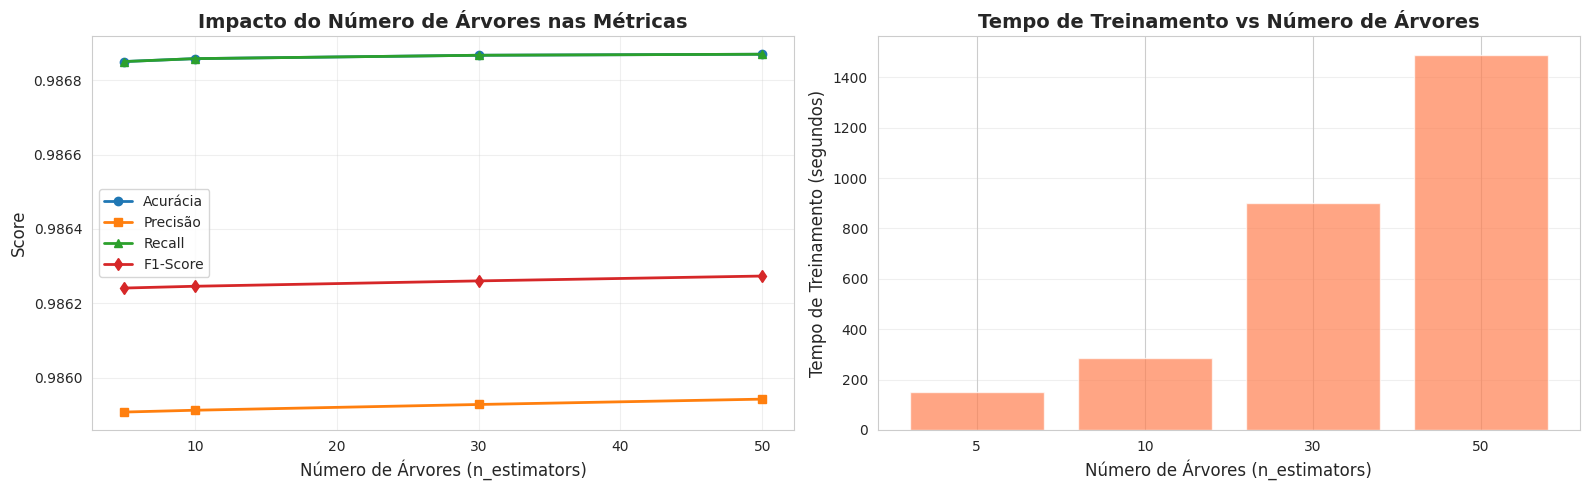


Tabela de Resultados:
 n_estimators  Acurácia  Precisão   Recall  F1-Score   Tempo (s)
            5  0.986850  0.985907 0.986850  0.986241  148.858924
           10  0.986858  0.985912 0.986858  0.986246  287.078472
           30  0.986867  0.985928 0.986867  0.986260  900.294343
           50  0.986870  0.985942 0.986870  0.986273 1488.602334


In [ ]:
# Criar DataFrame com resultados
df_n_est = pd.DataFrame({
    'n_estimators': n_estimators_values,
    'Acurácia': [r['accuracy'] for r in results_n_estimators],
    'Precisão': [r['precision'] for r in results_n_estimators],
    'Recall': [r['recall'] for r in results_n_estimators],
    'F1-Score': [r['f1_score'] for r in results_n_estimators],
    'Tempo (s)': [r['training_time'] for r in results_n_estimators]
})

# Plotar gráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Métricas vs n_estimators
ax1 = axes[0]
ax1.plot(df_n_est['n_estimators'], df_n_est['Acurácia'], marker='o', label='Acurácia', linewidth=2)
ax1.plot(df_n_est['n_estimators'], df_n_est['Precisão'], marker='s', label='Precisão', linewidth=2)
ax1.plot(df_n_est['n_estimators'], df_n_est['Recall'], marker='^', label='Recall', linewidth=2)
ax1.plot(df_n_est['n_estimators'], df_n_est['F1-Score'], marker='d', label='F1-Score', linewidth=2)
ax1.set_xlabel('Número de Árvores (n_estimators)', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Impacto do Número de Árvores nas Métricas', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Tempo de treinamento
ax2 = axes[1]
ax2.bar(df_n_est['n_estimators'].astype(str), df_n_est['Tempo (s)'], color='coral', alpha=0.7)
ax2.set_xlabel('Número de Árvores (n_estimators)', fontsize=12)
ax2.set_ylabel('Tempo de Treinamento (segundos)', fontsize=12)
ax2.set_title('Tempo de Treinamento vs Número de Árvores', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Mostrar tabela
print("\nTabela de Resultados:")
print(df_n_est.to_string(index=False))

## 8. Experimento 2: Variando a Profundidade Máxima (max_depth)

Agora vamos fixar n_estimators=100 e variar a profundidade máxima das árvores.

In [ ]:
# Valores a testar
max_depth_values = [5, 10, 20, 30, None]

# Armazenar resultados
results_max_depth = []

print("Testando diferentes valores de max_depth...")
print("=" * 80)

for max_d in max_depth_values:
    depth_str = str(max_d) if max_d is not None else "None"
    print(f"\nTreinando com max_depth={depth_str}...")

    model = RandomForestClassifier(
        n_estimators=20,
        max_depth=max_d,
        random_state=42,
        n_jobs=-1
    )

    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test,
                           f"RF (depth={depth_str})")
    results_max_depth.append(result)

    print(f"  Acurácia: {result['accuracy']:.4f}")
    print(f"  Tempo de treino: {result['training_time']:.2f}s")

print("\n" + "=" * 80)
print("✅ Experimento 2 concluído!")

Testando diferentes valores de max_depth...

Treinando com max_depth=5...
  Acurácia: 0.9869
  Tempo de treino: 273.75s

Treinando com max_depth=10...
  Acurácia: 0.9869
  Tempo de treino: 432.37s

Treinando com max_depth=20...
  Acurácia: 0.9869
  Tempo de treino: 586.74s

Treinando com max_depth=30...
  Acurácia: 0.9869
  Tempo de treino: 604.01s

Treinando com max_depth=None...
  Acurácia: 0.9869
  Tempo de treino: 611.33s

✅ Experimento 2 concluído!


### 8.1. Visualização dos Resultados - max_depth

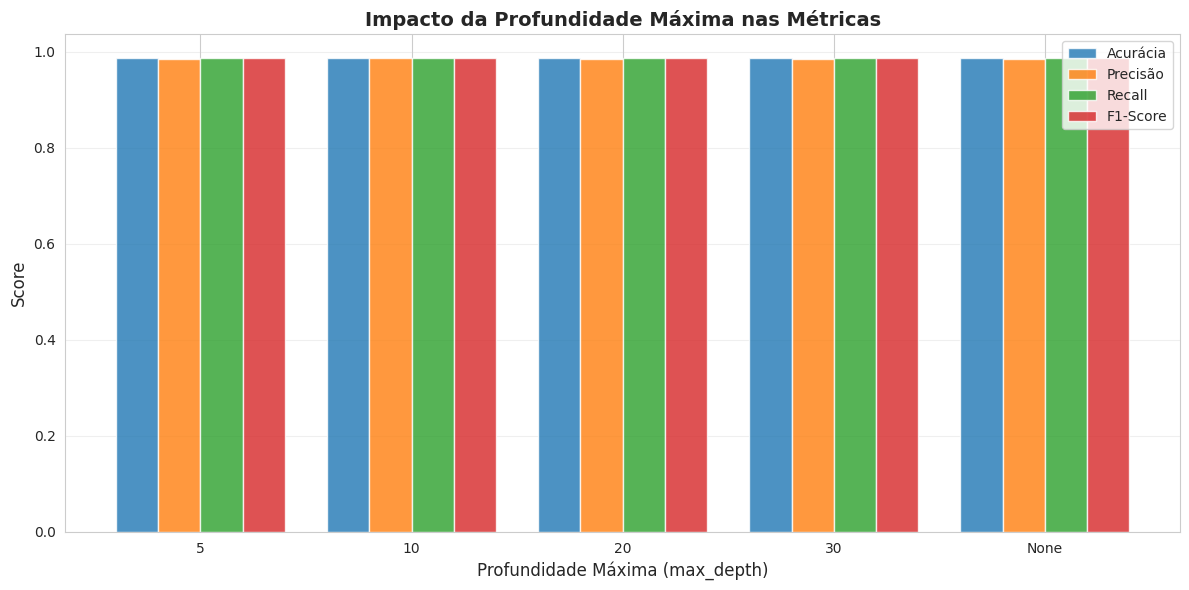


Tabela de Resultados:
max_depth  Acurácia  Precisão   Recall  F1-Score
        5  0.986871  0.985911 0.986871  0.986245
       10  0.986946  0.986053 0.986946  0.986377
       20  0.986878  0.985955 0.986878  0.986285
       30  0.986863  0.985922 0.986863  0.986255
     None  0.986863  0.985922 0.986863  0.986255


In [ ]:
# Criar DataFrame
depth_labels = [str(d) if d is not None else "None" for d in max_depth_values]
df_depth = pd.DataFrame({
    'max_depth': depth_labels,
    'Acurácia': [r['accuracy'] for r in results_max_depth],
    'Precisão': [r['precision'] for r in results_max_depth],
    'Recall': [r['recall'] for r in results_max_depth],
    'F1-Score': [r['f1_score'] for r in results_max_depth]
})

# Plotar
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(depth_labels))
width = 0.2

ax.bar(x - 1.5*width, df_depth['Acurácia'], width, label='Acurácia', alpha=0.8)
ax.bar(x - 0.5*width, df_depth['Precisão'], width, label='Precisão', alpha=0.8)
ax.bar(x + 0.5*width, df_depth['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + 1.5*width, df_depth['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Profundidade Máxima (max_depth)', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Impacto da Profundidade Máxima nas Métricas', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(depth_labels)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nTabela de Resultados:")
print(df_depth.to_string(index=False))

## 9. Experimento 3: Variando min_samples_split

Vamos testar o impacto do número mínimo de amostras para dividir um nó.

In [ ]:
# Valores a testar
min_samples_split_values = [2, 5, 10, 20, 50]

# Armazenar resultados
results_min_split = []

print("Testando diferentes valores de min_samples_split...")
print("=" * 80)

for min_split in min_samples_split_values:
    print(f"\nTreinando com min_samples_split={min_split}...")

    model = RandomForestClassifier(
        n_estimators=10,
        min_samples_split=min_split,
        random_state=42,
        n_jobs=-1
    )

    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test,
                           f"RF (min_split={min_split})")
    results_min_split.append(result)

    print(f"  Acurácia: {result['accuracy']:.4f}")

print("\n" + "=" * 80)
print("✅ Experimento 3 concluído!")

Testando diferentes valores de min_samples_split...

Treinando com min_samples_split=2...
  Acurácia: 0.9869

Treinando com min_samples_split=5...
  Acurácia: 0.9869

Treinando com min_samples_split=10...
  Acurácia: 0.9869

Treinando com min_samples_split=20...
  Acurácia: 0.9869

Treinando com min_samples_split=50...
  Acurácia: 0.9869

✅ Experimento 3 concluído!


## 10. Comparação de Matrizes de Confusão

Vamos comparar as matrizes de confusão dos melhores modelos de cada experimento.

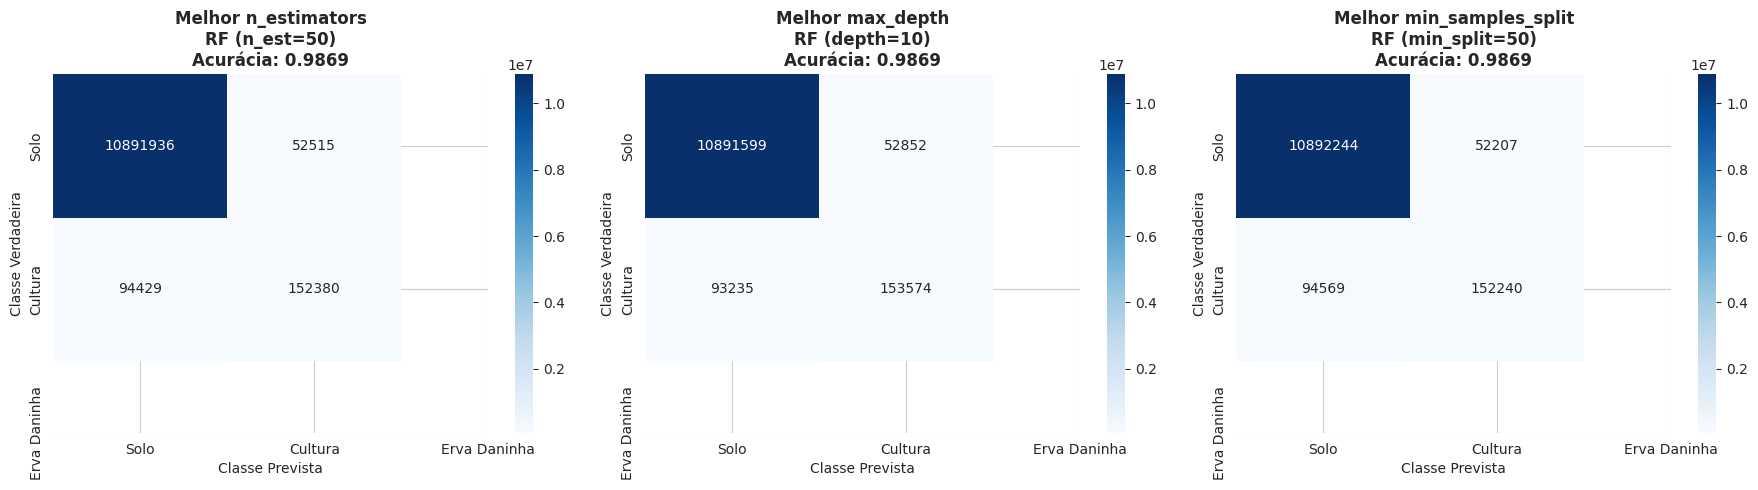

In [ ]:
# Selecionar os melhores modelos
best_n_est = max(results_n_estimators, key=lambda x: x['accuracy'])
best_depth = max(results_max_depth, key=lambda x: x['accuracy'])
best_split = max(results_min_split, key=lambda x: x['accuracy'])

# Plotar matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_to_plot = [
    (best_n_est, axes[0], "Melhor n_estimators"),
    (best_depth, axes[1], "Melhor max_depth"),
    (best_split, axes[2], "Melhor min_samples_split")
]

for result, ax, title in models_to_plot:
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names.values(),
                yticklabels=class_names.values())
    ax.set_title(f"{title}\n{result['model_name']}\nAcurácia: {result['accuracy']:.4f}",
                fontsize=12, fontweight='bold')
    ax.set_ylabel('Classe Verdadeira')
    ax.set_xlabel('Classe Prevista')

plt.tight_layout()
plt.show()

## 11. Análise Detalhada: Métricas por Classe

Vamos analisar como cada classe se comporta individualmente.

Melhor modelo: RF (depth=10)
Acurácia geral: 0.9869

Relatório de Classificação Detalhado:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

              precision    recall  f1-score   support

        Solo       0.99      1.00      0.99  10944451
     Cultura       0.00      0.00      0.00         0
Erva Daninha       0.74      0.62      0.68    246809

    accuracy                           0.99  11191260
   macro avg       0.58      0.54      0.56  11191260
weighted avg       0.99      0.99      0.99  11191260



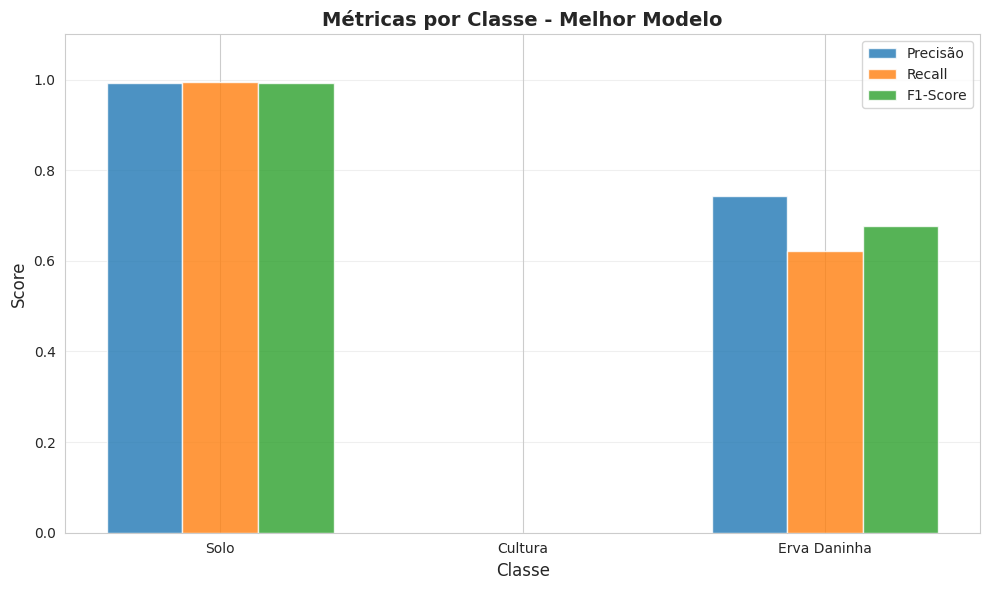


Tabela de Métricas por Classe:
      Classe  Precisão   Recall  F1-Score
        Solo  0.991512 0.995171  0.993338
     Cultura  0.000000 0.000000  0.000000
Erva Daninha  0.743966 0.622238  0.677679


In [ ]:
# Usar o melhor modelo geral
best_overall = max(results_n_estimators + results_max_depth + results_min_split,
                   key=lambda x: x['accuracy'])

print(f"Melhor modelo: {best_overall['model_name']}")
print(f"Acurácia geral: {best_overall['accuracy']:.4f}\n")

# Relatório de classificação detalhado
print("Relatório de Classificação Detalhado:")
print("=" * 80)
report = classification_report(y_test, best_overall['y_pred'],
                              target_names=class_names.values(),
                              labels=list(class_names.keys()))
print(report)

# Calcular métricas por classe
precision_per_class = precision_score(y_test, best_overall['y_pred'],
                                     average=None, labels=list(class_names.keys()), zero_division=0)
recall_per_class = recall_score(y_test, best_overall['y_pred'],
                               average=None, labels=list(class_names.keys()), zero_division=0)
f1_per_class = f1_score(y_test, best_overall['y_pred'],
                       average=None, labels=list(class_names.keys()), zero_division=0)

# Criar DataFrame
df_per_class = pd.DataFrame({
    'Classe': list(class_names.values()),
    'Precisão': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

# Plotar
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, df_per_class['Precisão'], width, label='Precisão', alpha=0.8)
ax.bar(x, df_per_class['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, df_per_class['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Métricas por Classe - Melhor Modelo', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names.values())
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\nTabela de Métricas por Classe:")
print(df_per_class.to_string(index=False))

## 12. Interpretação das Métricas

### 12.1. Entendendo as Métricas

**Acurácia (Accuracy)**
- Proporção de predições corretas em relação ao total
- Fórmula: (VP + VN) / (VP + VN + FP + FN)
- **Quando usar:** Quando as classes estão balanceadas
- **Limitação:** Pode ser enganosa em datasets desbalanceados

**Precisão (Precision)**
- Proporção de predições positivas que estão corretas
- Fórmula: VP / (VP + FP)
- **Quando usar:** Quando o custo de Falsos Positivos é alto
- **Exemplo:** Evitar classificar solo como erva daninha (economizar herbicida)

**Recall (Sensibilidade)**
- Proporção de casos positivos que foram corretamente identificados
- Fórmula: VP / (VP + FN)
- **Quando usar:** Quando o custo de Falsos Negativos é alto
- **Exemplo:** Detectar todas as ervas daninhas (não deixar nenhuma passar)

**F1-Score**
- Média harmônica entre Precisão e Recall
- Fórmula: 2 × (Precisão × Recall) / (Precisão + Recall)
- **Quando usar:** Quando você precisa balancear Precisão e Recall

### 12.2. Matriz de Confusão

A matriz de confusão mostra onde o modelo está acertando e errando:

|                | Previsto: Solo | Previsto: Cultura | Previsto: Erva |
|----------------|----------------|-------------------|----------------|
| **Real: Solo** | VP (Solo)      | FP (Cultura)      | FP (Erva)      |
| **Real: Cultura** | FN (Solo)   | VP (Cultura)      | FP (Erva)      |
| **Real: Erva** | FN (Solo)      | FN (Cultura)      | VP (Erva)      |

- **Diagonal principal:** Classificações corretas
- **Fora da diagonal:** Erros do modelo

### 12.3. Trade-offs

- **Precisão vs Recall:** Aumentar um geralmente diminui o outro
- **Complexidade vs Generalização:** Modelos muito complexos podem fazer overfitting
- **Performance vs Tempo:** Mais árvores melhoram a performance mas aumentam o tempo

## 13. Conclusões e Recomendações

### 13.1. Principais Descobertas

Com base nos experimentos realizados:

1. **n_estimators:** Aumentar o número de árvores geralmente melhora a performance até um ponto de saturação (geralmente entre 100-200 árvores)

2. **max_depth:** Profundidade ilimitada (None) tende a dar melhores resultados em datasets grandes, mas pode causar overfitting em datasets pequenos

3. **min_samples_split:** Valores muito baixos (2-5) funcionam bem quando há muitos dados, valores maiores ajudam a prevenir overfitting

### 13.2. Recomendações para Produção

Para o problema de detecção de ervas daninhas:

- **Configuração recomendada:**
  - `n_estimators`: 100-200
  - `max_depth`: None ou 30
  - `min_samples_split`: 2-5
  - `min_samples_leaf`: 1-2
  - `max_features`: 'sqrt'

### 13.3. Próximos Passos

1. **Grid Search:** Usar `GridSearchCV` para encontrar a melhor combinação de hiperparâmetros automaticamente
2. **Cross-Validation:** Validar os resultados com validação cruzada
3. **Feature Engineering:** Adicionar mais features (outras bandas espectrais, índices de vegetação)
4. **Ensemble Methods:** Combinar Random Forest com outros algoritmos
5. **Análise de Importância:** Verificar quais features são mais importantes para o modelo

## 14. Exercício Extra: Grid Search Automático

Vamos usar `GridSearchCV` para encontrar automaticamente a melhor combinação de hiperparâmetros.

**Atenção:** Este processo pode demorar bastante! Considere usar um subset menor dos dados ou menos combinações.

In [ ]:
# OPCIONAL: Usar apenas uma amostra dos dados para acelerar
# Descomente as linhas abaixo se quiser testar com menos dados
# sample_size = 50000
# sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
# X_train_sample = X_train_scaled[sample_indices]
# y_train_sample = y_train[sample_indices]

# Definir grid de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Iniciando Grid Search...")
print(f"Total de combinações: {np.prod([len(v) for v in param_grid.values()])}")
print("Isso pode demorar vários minutos...\n")

# Criar modelo base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Treinar (comentado por padrão para não travar o notebook)
# Descomente para executar
# grid_search.fit(X_train_scaled, y_train)

# print("\n" + "=" * 80)
# print("Grid Search concluído!")
# print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
# print(f"Melhor acurácia (CV): {grid_search.best_score_:.4f}")

# # Avaliar no conjunto de teste
# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test_scaled)
# test_accuracy = accuracy_score(y_test, y_pred_best)
# print(f"Acurácia no teste: {test_accuracy:.4f}")

## Referências

1. Breiman, L. (2001). Random forests. *Machine Learning*, 45(1), 5-32.

2. Scikit-learn Documentation: Random Forest Classifier. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

3. Sa, I., et al. (2018). WeedMap: A large-scale semantic weed mapping framework using aerial multispectral imaging and deep neural network for precision farming. *Remote Sensing*, 10(9), 1423.

4. Sokolova, M., & Lapalme, G. (2009). A systematic analysis of performance measures for classification tasks. *Information processing & management*, 45(4), 427-437.

---

**Autor:** Prof. Eduardo Nunes  
**Instituição:** UNICAMP  
**Disciplina:** Mineração de Dados